<a href="https://colab.research.google.com/github/noayarae/Machine_Learning_notes/blob/main/ML_model_present_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# forecast monthly births with xgboost
# import lybraries
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

import xgboost
print("xgboost", xgboost.__version__)

xgboost 0.90


In [ ]:
# transform a time series dataset into a supervised learning dataset
# ---------------- Function 1 ------------------
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

### To test
'''values = [10, 20, 30, 40, 50, 60, 70, 80, 90]
data = series_to_supervised(values, n_in=2) # 'n_in' is the lag
print (values)
print (data)
[10, 20, 30, 40, 50, 60, 70, 80, 90]
[[10. 20. 30.]
 [20. 30. 40.]
 [30. 40. 50.]
 [40. 50. 60.]
 [50. 60. 70.]
 [60. 70. 80.]
 [70. 80. 90.]] #'''

In [25]:
import numpy as np
# split a univariate dataset into train/test sets
# ------------ Function 2a -------------
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
# ------------ Function 2b -------------
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0], model

# walk-forward validation for univariate data
# --------------- Function 2 ------------------
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)      #   -------> Function 2a
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat, model = xgboost_forecast(history, testX)         #   ------> Function 2b
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions, model

In [34]:
### load the dataset ('birth_data.csv')
#series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
series = read_csv('birth_data.csv', header=0, index_col=0)
values = series.values
#print (values)

In [ ]:
### load the dataset ('stream_temp.csv')
import numpy as np
df1 = read_csv('stream_temp.csv', header=0, index_col=0)
#print (df1)
df2 = df1[['ta_0','sr','rh','wd','pp','tw']] # Select only variables to work
print (df2)
npa = np.asarray(df2, dtype=np.float32) # Convert data into numpy array
print (npa)

In [ ]:
### load the dataset ('strm_temp_sb31.csv')
import numpy as np
d1 = read_csv('strm_temp_sb31.csv', header=0, index_col=0)
#print (d1)
d2 = d1[['t_air','s_rad','rh','wind','snow','gw','s_flow','lat_f','sb_yld','tw']] 
print (d2)
npa2 = np.asarray(d2, dtype=np.float32) # Convert pandas data-frame to np array
print (npa2)

In [ ]:
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=2) # 'n_in' is the # of lags -------> Function 1
data = npa2 # Get values directly from above 'strm_temp_sb31.csv'
print (len(values),len(data))
print (data)

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


>expected=6.0, predicted=6.5
>expected=7.1, predicted=7.0
>expected=7.5, predicted=8.0
>expected=6.8, predicted=7.6
>expected=6.6, predicted=6.4
>expected=6.6, predicted=6.8
>expected=6.9, predicted=7.4
>expected=7.7, predicted=8.3
>expected=7.3, predicted=8.4
>expected=5.8, predicted=6.4
MAE: 0.501


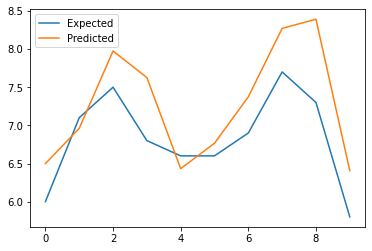

In [48]:
# evaluate
# walk_forward_validation(data, 40 predictions)
mae, y, yhat, model = walk_forward_validation(data, 10)  #      --------> Function 2
print('MAE: %.3f' % mae)
#print('RMSE: %.3f' % rmse)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

[0.8333061  0.01464248 0.00886022 0.01325608 0.00796375 0.01857714
 0.00328388 0.07597035 0.02414   ]


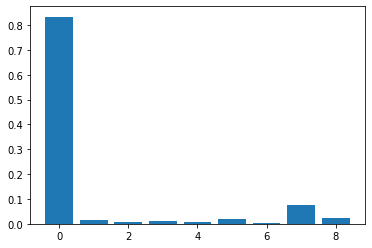

In [32]:
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [43]:
# evaluate an xgboost regression model on the housing dataset
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
print (len(data), len(data[0]))
# split data into input and output columns
X, y = data[:, :-1], data[:, -1]
# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
print (cv)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

506 14
RepeatedKFold(n_repeats=3, n_splits=10, random_state=1)
Mean MAE: 2.146 (0.328)


In [44]:
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=2652124)
print (rkf.split(X))

<generator object _RepeatedSplits.split at 0x7f96a956cdd0>
